## Data Analitics Project - Tornadoes in US

Authors: Roman Dembrovskyi, Maciej Morgalla

In this project we try to create a model that shows in which days tornado is most likely to occur in United States. This is very important issue for everyone who lives or visits US, because tornadoes might endanger human lives. It can be aldo usefull for meteorologist in weather predicting. Finally we can predict days with tornado for next years.

Data comes from page: https://www.spc.noaa.gov/wcm/#data . Data was collected by NOAA - american government institution collecting information about weather. Data contains informations about tornadoes in years 1950-2020. Dataset contains information about: date of occurace (three separate columns respectivaly for day, month and year: dy, mo, yr),timezone and time of start and end of occurance as in form of hours-minutes-seconds, place of occurance (state and city), power of the tornado. Tornadoes power level is measured in so-called Fujita scale which divides tornadoes into different categories (F1-F5) based on the speed of wind in the epicenter.

At first we download data and create dictionary that change original dates to days of year (for example: 28th of February -> 59th day of year).

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import arviz as az
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel

w=pd.read_csv("1950-2020_all_tornadoes.csv")

x=np.linspace(1,366,366)

year={}
year['1']=0
year['2']=31
year['3']=59
year['4']=90
year['5']=120
year['6']=151
year['7']=181
year['8']=212
year['9']=243
year['10']=273
year['11']=304
year['12']=334

Now we can check how many tornadoes occured in specific day of year:

Text(0, 0.5, 'Amount of tornadoes')

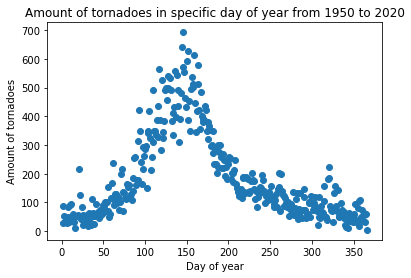

In [2]:
tornadoes=np.zeros([366])
for i in range(len(w['mo'])):
    day=int(w['dy'][i])
    month=str(w['mo'][i])
    mm=year[month]
    ww=day+mm
    if str(w['mo'][i])=='2'and str(w['dy'][i])=='29' or w['yr'][i]%4==0 and str(w['mo'][i])!='1' and str(w['mo'][i])!='2':
        ww=ww+1
    tornadoes[ww-1]=tornadoes[ww-1]+1
    
plt.plot(x,tornadoes,'o')
plt.title("Amount of tornadoes in specific day of year from 1950 to 2020")
plt.xlabel('Day of year')
plt.ylabel('Amount of tornadoes')

Unfortunately the chart is not good. There can be a day when weather condiotions where specific and more tornadoes can occur then in simple day. Thatis why we will count only days when tornado occured.

Text(0, 0.5, 'Amount of days when tornado occurred')

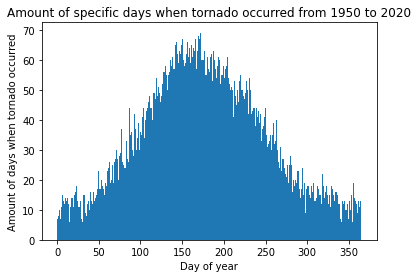

In [3]:
lista=[]
days=[]

for i in range(len(w['mo'])):
    if w['date'][i] not in lista:
        lista.append(w['date'][i])
        day=int(w['dy'][i])
        month=str(w['mo'][i])
        mm=year[month]
        ww=day+mm
        if str(w['mo'][i])=='2'and str(w['dy'][i])=='29' or w['yr'][i]%4==0 and str(w['mo'][i])!='1' and str(w['mo'][i])!='2':
            ww=ww+1
        days.append(ww-1)
        if ww==366:
            days.append(ww-1)
            days.append(ww-1)
            days.append(ww-1)
plt.hist(days,bins=366)
plt.title("Amount of specific days when tornado occurred from 1950 to 2020")
plt.xlabel('Day of year')
plt.ylabel('Amount of days when tornado occurred')

Now we have beautiful chart that shows us how many times tornado occured in x day of year from 1950 to 2020. The next step is creating two models.

## Model 1

In [3]:
with open('model1_ppc.stan') as file:
    print(file.read())


generated quantities {
    real mu=normal_rng(174,4);
    real sigma=lognormal_rng(4.4,0.04);    
    real prob = normal_rng(mu,sigma);
}


In [4]:
model1_ppc=CmdStanModel(stan_file='model1_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [5]:
data=dict(N=366,torns=tornadoes)
m1=model1_ppc.sample(iter_sampling=12124,chains=1,fixed_param=True)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


Text(0.5, 1.0, 'sigma')

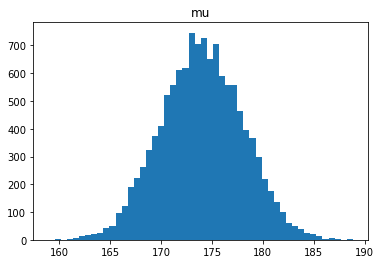

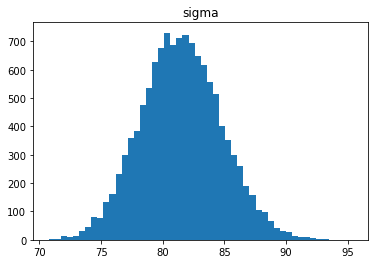

In [6]:
mu1=m1.stan_variable('mu')
sigma1=m1.stan_variable('sigma')
prob1=m1.stan_variable('prob')

plt.hist(mu1,bins=50)[2]
plt.title("mu")
plt.figure()
plt.hist(sigma1,bins=50)[2]
plt.title("sigma")

Text(0.5, 1.0, 'Comparison between real data and generated data')

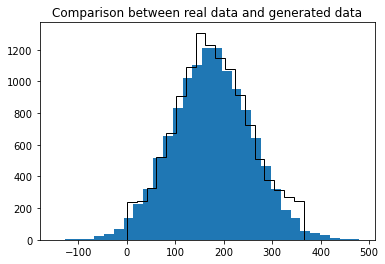

In [7]:
a=max(prob1)
b=min(prob1)

plt.hist(prob1,bins=int((a-b)/20))[2]
plt.hist(days,bins=int(366/20),histtype='step',color='black')[2]
plt.title("Comparison between real data and generated data")

In [4]:
with open('model1_fit.stan') as file:
    print(file.read())

data{
    int N;
    real probs[N];
}

parameters{
    real mu;
    real<lower=0> sigma;

}

model{
    mu ~ normal(174,4);
    sigma ~ lognormal(4.4,0.04);    
    probs ~ normal(mu,sigma);

}

generated quantities {
    vector[N] log_lik;
    vector[N] prob;
    
    for (i in 1:N){
        prob[i] = normal_rng(mu,sigma);
        log_lik[i] = normal_lpdf(probs[i]|mu,sigma);
        
    }
}


In [8]:
model1_fit=CmdStanModel(stan_file='model1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [9]:
data=dict(N=len(days),probs=days)
m2=model1_fit.sample(data=data,iter_sampling=10,chains=1)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


Text(0.5, 1.0, 'sigma')

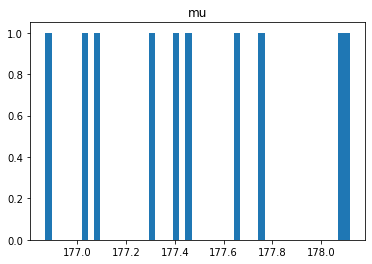

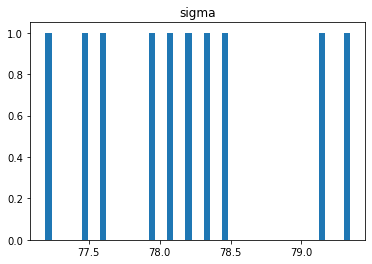

In [10]:
mu2=m2.stan_variable('mu')
sigma2=m2.stan_variable('sigma')
prob2=m2.stan_variable('prob')

plt.hist(mu2,bins=50)[2]
plt.title("mu")
plt.figure()
plt.hist(sigma2,bins=50)[2]
plt.title("sigma")

Text(0.5, 1.0, 'Comparison between real data and generated data from model')

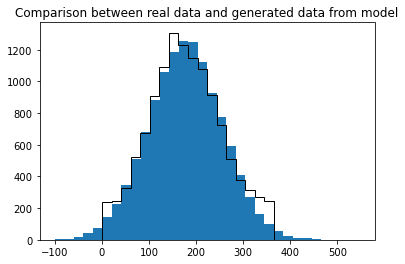

In [11]:
m=0
a=max(prob2[m])
b=min(prob2[m])

plt.hist(prob2[m],bins=int((a-b)/20))[2]
plt.hist(days,bins=int(366/20),histtype='step',color='black')[2]
plt.title("Comparison between real data and generated data from model")


In [5]:
with open('model2_ppc.stan') as file:
    print(file.read())

generated quantities{
    real mu=normal_rng(174,4);
    real sigma=lognormal_rng(4.4,0.04);
    real nu=lognormal_rng(2.7,0.1);
    real prob = student_t_rng(nu,mu,sigma);
}


In [12]:
model2_ppc=CmdStanModel(stan_file='model2_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [13]:
data=dict(mu1=2.7,sigma1=0.1)
m3=model2_ppc.sample(data=data,iter_sampling=12124,chains=1,fixed_param=True)


INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


Text(0.5, 1.0, 'nu')

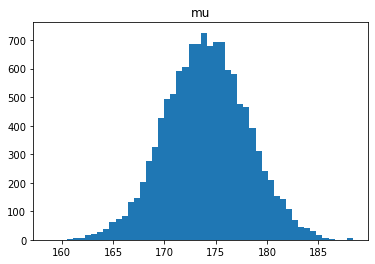

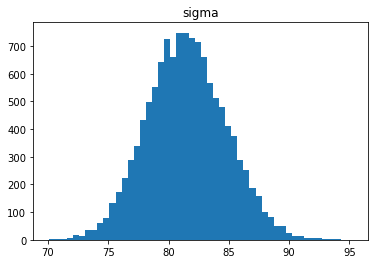

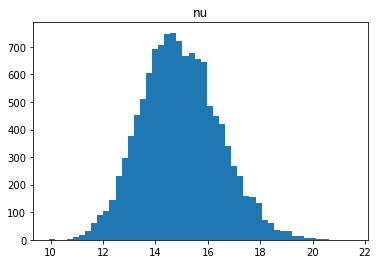

In [14]:
prob3=m3.stan_variable('prob')
mu3=m3.stan_variable('mu')
sigma3=m3.stan_variable('sigma')
nu3=m3.stan_variable('nu')

plt.hist(mu3,bins=50)[2]
plt.title("mu")
plt.figure()
plt.hist(sigma3,bins=50)[2]
plt.title("sigma")
plt.figure()
plt.hist(nu3,bins=50)[2]
plt.title("nu")

Text(0.5, 1.0, 'Comparison between real data and generated data')

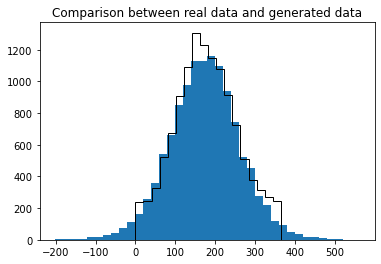

In [15]:
a=max(prob3)
b=min(prob3)

plt.hist(prob3,bins=int((a-b)/20))[2]
plt.hist(days,bins=int(366/20),histtype='step',color='black')[2]
plt.title('Comparison between real data and generated data')


In [6]:
with open('model2_fit.stan') as file:
    print(file.read())

data{
    int N;
    real probs[N];
}

parameters{
    real mu;
    real nu;
    real<lower=0> sigma;
}


model{
    mu ~ normal(174,4);
    sigma ~ lognormal(4.4,0.04);
    nu ~ lognormal(2.7,0.1);
    probs ~ student_t(nu,mu,sigma);

}

generated quantities {
    vector[N] log_lik;
    vector[N] prob;
    
    for (i in 1:N){
        log_lik[i] = student_t_lpdf(probs[i]|nu,mu,sigma);
        prob[i] = student_t_rng(nu,mu,sigma);
    }
    

}


In [16]:
model2_fit=CmdStanModel(stan_file='model2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [17]:
data4=dict(N=len(days),probs=days)
m4=model2_fit.sample(data=data4,iter_sampling=10,chains=1)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


Text(0.5, 1.0, 'nu')

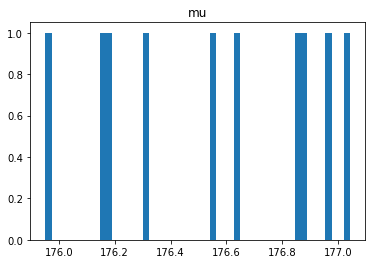

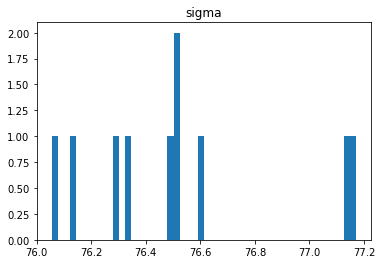

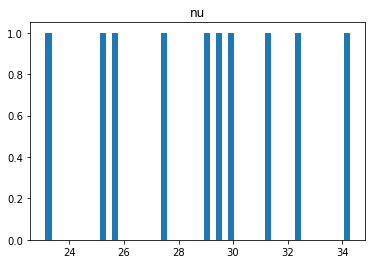

In [18]:
prob4=m4.stan_variable('prob')
mu4=m4.stan_variable('mu')
sigma4=m4.stan_variable('sigma')
nu4=m4.stan_variable('nu')

plt.hist(mu4,bins=50)[2]
plt.title("mu")
plt.figure()
plt.hist(sigma4,bins=50)[2]
plt.title("sigma")
plt.figure()
plt.hist(nu4,bins=50)[2]
plt.title("nu")

Text(0.5, 1.0, 'Comparison between real data and generated data from model')

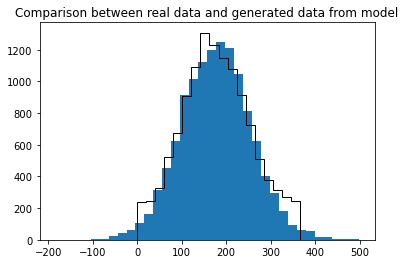

In [19]:
m=0
a=max(prob4[m])
b=min(prob4[m])

plt.hist(prob4[m],bins=int((a-b)/20))[2]
plt.hist(days,bins=int(366/20),histtype='step',color='black')[2]
plt.title("Comparison between real data and generated data from model")


In [20]:
az.loo(m2)

C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 10 by 12130 log-likelihood matrix

         Estimate       SE
elpd_loo -70094.23    70.16
p_loo        1.68        -

There has been a warning during the calculation. Please check the results.

In [21]:
az.loo(m4)

C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 10 by 12130 log-likelihood matrix

         Estimate       SE
elpd_loo -70138.08    70.69
p_loo        0.61        -

There has been a warning during the calculation. Please check the results.

In [22]:
az.waic(m2)

Computed from 10 by 12130 log-likelihood matrix

          Estimate       SE
elpd_waic -70094.23    70.16
p_waic        1.68        -

In [23]:
az.waic(m4)

Computed from 10 by 12130 log-likelihood matrix

          Estimate       SE
elpd_waic -70138.08    70.69
p_waic        0.61        -

In [24]:
com1=az.from_cmdstanpy(m2)
com2=az.from_cmdstanpy(m4)

w53=az.compare({"1":com1,"2":com2})
w53

C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
1,0,-70094.226662,1.676008,0.000000,1.000000e+00,70.163409,0.000000,True,log
2,1,-70138.084069,0.605331,43.857407,2.451372e-12,70.690614,2.098411,True,log


<AxesSubplot:xlabel='Log'>

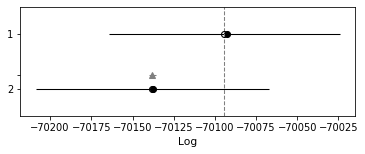

In [25]:
az.plot_compare(w53)